# 2. Projected outcome damage classification client

In [1]:
# import dependencies

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

C:\Users\denis\AppData\Local\Temp\ipykernel_23508\816365406.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Read in file
df = pd.read_csv('train_V2_cleaned.csv')

# Convert dummy features
df.iloc[:,25:58] = df.iloc[:,25:58].astype('category')

# Show conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   income_am              4947 non-null   float64 
 1   profit_last_am         4947 non-null   float64 
 2   profit_am              4947 non-null   float64 
 3   damage_am              4947 non-null   float64 
 4   damage_inc             4947 non-null   int64   
 5   crd_lim_rec            4947 non-null   float64 
 6   cab_requests           4947 non-null   int64   
 7   bar_no                 4947 non-null   int64   
 8   neighbor_income        4947 non-null   float64 
 9   age                    4947 non-null   int64   
 10  client_segment         4947 non-null   int64   
 11  sect_empl              4947 non-null   int64   
 12  fam_adult_size         4947 non-null   int64   
 13  children_no            4947 non-null   int64   
 14  tenure_mts             4947 non-null   i

In [3]:
# Dropping the features that need to be predicted EXCEPT the feature 'outcome_profit'.

drop_columns = ["outcome_profit", "outcome_damage_amount"]

for col in drop_columns:
	if col in df.columns:
		df = df.drop(col, axis=1)

print("train", df.shape)

train (4947, 57)


In [4]:
df['outcome_damage_inc'].value_counts()

0    3682
1    1265
Name: outcome_damage_inc, dtype: int64

## 2.1 Train/test-spit and standardisation

### 2.1.1 Shuffle data

In [5]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)

### 2.1.2 Train/test-split

In [6]:
from sklearn.model_selection import train_test_split

X = df_shuffle.drop(['outcome_damage_inc'],1)
y = df_shuffle['outcome_damage_inc']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=4321)

C:\Users\denis\AppData\Local\Temp\ipykernel_23508\3604566307.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['outcome_damage_inc'],1)


### 2.1.3 Standardise

In [7]:
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_trainval_stand = X_trainval.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()


X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])

X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

## 2.2 Models training and testing

### 2.2.1 Logistic regression

In [8]:
# Train a logistic model

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10000, max_iter=200) 
logreg.fit(X_train_stand, y_train)

LogisticRegression(C=10000, max_iter=200)

In [9]:
# retrieve the scores from the train and validation data
 
print(logreg.score(X_train_stand, y_train))
print(logreg.score(X_val_stand, y_val))

0.7633491311216429
0.7424242424242424


In [10]:
# predict the outcomes for the validation dataset

y_val_pred = logreg.predict(X_val_stand)
y_val_pred_prob = logreg.predict_proba(X_val_stand)

In [11]:
# construct the confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val, y_val_pred)
print(confusion_matrix)

[[565  25]
 [179  23]]


In [12]:
# print the classification report

from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       590
           1       0.48      0.11      0.18       202

    accuracy                           0.74       792
   macro avg       0.62      0.54      0.52       792
weighted avg       0.69      0.74      0.68       792



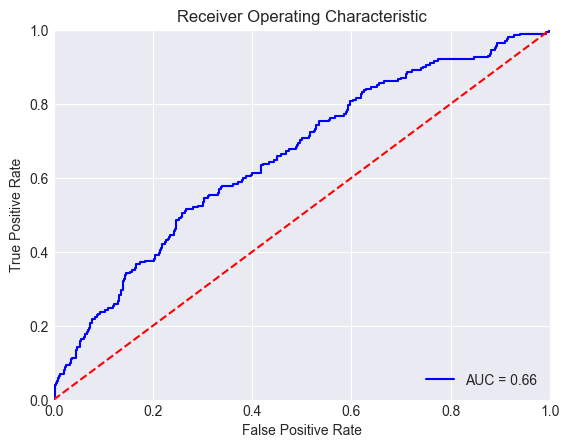

In [13]:
# print the ROC-curve

import sklearn.metrics as metrics
preds = y_val_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 2.2.2 Calibration

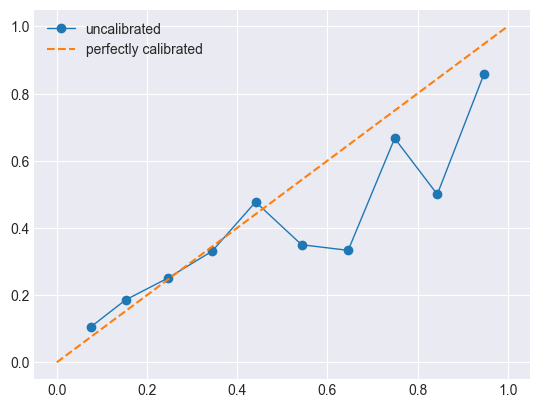

In [14]:
from sklearn.calibration import calibration_curve
y_pred_val_prob = logreg.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()

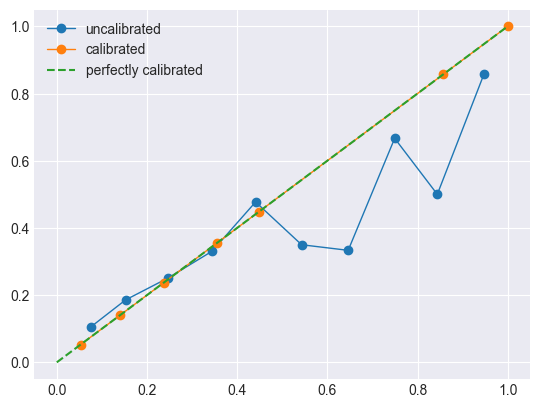

In [15]:
# plotting a perfectly calibrated, calibrated and uncalibrated plot 

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
isotonic = CalibratedClassifierCV(logreg, cv='prefit', method='isotonic')
isotonic.fit(X_val_stand, y_val)

y_val_pred_prob_c = isotonic.predict_proba(X_val_stand)
fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_val,y_val_pred_prob_c[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()
plt.show()

In [16]:
# Constructing the classification report

y_pred = logreg.predict(X_val_stand)
y_pred_c = isotonic.predict(X_val_stand)

print(classification_report(y_val, y_pred))
print(classification_report(y_val, y_pred_c))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       590
           1       0.48      0.11      0.18       202

    accuracy                           0.74       792
   macro avg       0.62      0.54      0.52       792
weighted avg       0.69      0.74      0.68       792

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       590
           1       0.89      0.04      0.08       202

    accuracy                           0.75       792
   macro avg       0.82      0.52      0.47       792
weighted avg       0.79      0.75      0.66       792



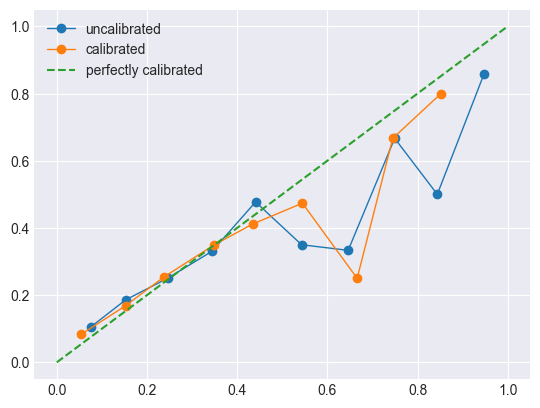

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       590
           1       0.89      0.04      0.08       202

    accuracy                           0.75       792
   macro avg       0.82      0.52      0.47       792
weighted avg       0.79      0.75      0.66       792

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       590
           1       0.52      0.11      0.19       202

    accuracy                           0.75       792
   macro avg       0.64      0.54      0.52       792
weighted avg       0.70      0.75      0.68       792



In [17]:
# Fitting and calibrating the model also displaying the classification report at the end

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
logreg2 = LogisticRegression(C=10000, max_iter=1000) 
isotonic2 = CalibratedClassifierCV(logreg2, cv=5, method='isotonic')
isotonic2.fit(X_train_stand, y_train)


# The calibration plot

y_val_pred_prob_c2 = isotonic2.predict_proba(X_val_stand)
fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_val,y_val_pred_prob_c2[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()
plt.show()

y_pred_c2 = isotonic2.predict(X_val_stand)
print(classification_report(y_val, y_pred_c))
print(classification_report(y_val, y_pred_c2))

### 2.2.3 Polynomials and penalisation

In [18]:
# designing the polynomial features

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_stand)
X_trainval_poly = poly.transform(X_trainval_stand)
X_val_poly = poly.transform(X_val_stand)

In [19]:
# Performing the RandomSearch with cross validation 

from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

C = [round(x,5) for x in np.linspace(start = 0.0001, stop = 10, num = 1000)]
random_grid = {'C': C}

logreg = LogisticRegression(max_iter=1000) 
log_random = RandomizedSearchCV(estimator=logreg, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, n_jobs=-1, random_state=1234)
log_random.fit(X_train_poly, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.01011, 0.02012, 0.03013,
                                              0.04014, 0.05015, 0.06016,
                                              0.07017, 0.08018, 0.09019, 0.1002,
                                              0.11021, 0.12022, 0.13023,
                                              0.14024, 0.15025, 0.16026,
                                              0.17027, 0.18028, 0.19029, 0.2003,
                                              0.21031, 0.22032, 0.23033,
                                              0.24034, 0.25035, 0.26036,
                                              0.27037, 0.28038, 0.29039, ...]},
                   random_state=1234, verbose=2)

In [20]:
log_random.best_params_

{'C': 0.78087}

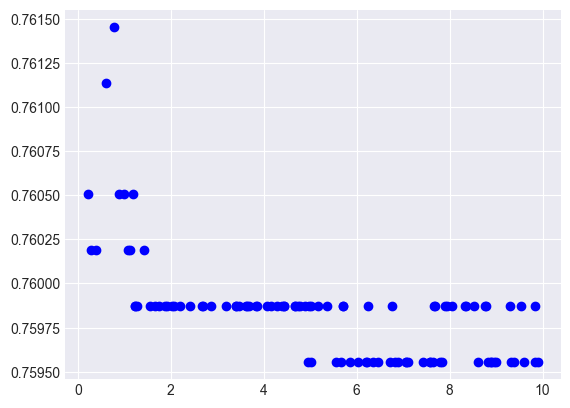

In [21]:
# plotting the scores

out2 = pd.DataFrame(log_random.cv_results_)
plt.ylim(out2['mean_test_score'].min()-0.0001, out2['mean_test_score'].max()+0.0001)
plt.scatter(out2['param_C'], out2['mean_test_score'], c='blue')


### 2.2.4 Grid search

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

prec_scorer = make_scorer(metrics.accuracy_score)

C = [x for x in np.linspace(start=0.0001, stop=1, num=50)]

random_grid = {'C': C}

logreg_balanced = LogisticRegression(max_iter=1000) 

log_grid = GridSearchCV(estimator=logreg_balanced, param_grid=random_grid, scoring=prec_scorer, cv=3, verbose=2,  n_jobs=-1)
isotonic_log = CalibratedClassifierCV(log_grid, cv=3, method='isotonic')

#Fitting model (model+ calibration)
isotonic_log.fit(X_train_poly, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=LogisticRegression(max_iter=1000),
                                              n_jobs=-1,
                                              param_grid={'C': [0.0001,
                                                                0.02050612244897959,
                                                                0.04091224489795919,
                                                                0.06131836734693878,
                                                                0.08172448979591837,
                                                                0.10213061224489796,
                                                                0.12253673469387756,
                                                                0.14294285714285712,
                                                                0.16334897959183672,
                                                                0.18375510204081633,
                                                                0.2041612244897959,
                                                                0.224567346938775...
                                                                0.30619183673469386,
                                                                0.32659795918367346,
                                                                0.34700408163265306,
                                                                0.36741020408163266,
                                                                0.3878163265306122,
                                                                0.4082224489795918,
                                                                0.4286285714285714,
                                                                0.449034693877551,
                                                                0.4694408163265306,
                                                                0.4898469387755102,
                                                                0.5102530612244898,
                                                                0.5306591836734694,
                                                                0.551065306122449,
                                                                0.5714714285714285,
                                                                0.5918775510204082, ...]},
                                              scoring=make_scorer(accuracy_score),
                                              verbose=2),
                       method='isotonic')

In [23]:
# evaluation

isotonic_log.score(X_val_poly, y_val)

0.7411616161616161

In [24]:
# classification report

y_pred_poly = isotonic_log.predict(X_val_poly)
print(classification_report(y_val, y_pred_poly))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       590
           1       0.47      0.10      0.17       202

    accuracy                           0.74       792
   macro avg       0.61      0.53      0.51       792
weighted avg       0.68      0.74      0.67       792



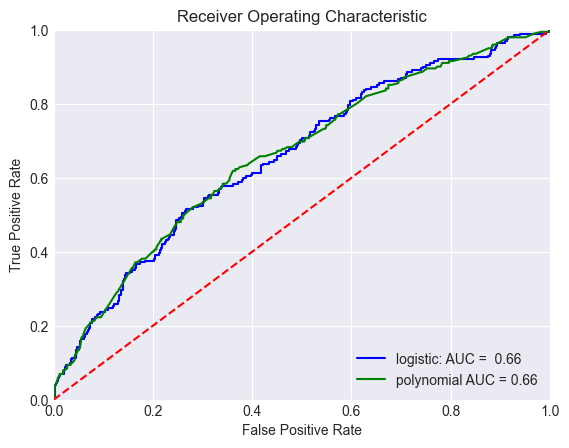

In [25]:
# plotting the polynomial AUC together with the last one

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = y_val_pred_prob[:,1]
preds_poly = isotonic_log.predict_proba(X_val_poly)[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 2.2.5 KNN Classification

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
n_neighbors = np.arange(1,30)
param_grid = {'n_neighbors': n_neighbors}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=prec_scorer ,cv=3,  verbose=2, n_jobs=-1)

grid_search.fit(X_train_stand, y_train)
grid_search.best_params_

Fitting 3 folds for each of 29 candidates, totalling 87 fits


{'n_neighbors': 28}

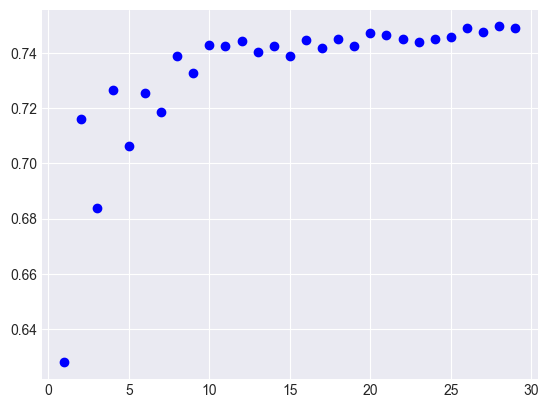

In [27]:
out2 = pd.DataFrame(grid_search.cv_results_)
xlabel_names = ['n_neighbors']
plt.scatter(out2['param_n_neighbors'], out2['mean_test_score'], c='blue')

In [28]:
# classification report

y_pred_knn = grid_search.predict(X_val_stand)
print(classification_report(y_val, y_pred_knn))

              precision    recall  f1-score   support

           0       0.75      0.99      0.86       590
           1       0.67      0.03      0.06       202

    accuracy                           0.75       792
   macro avg       0.71      0.51      0.46       792
weighted avg       0.73      0.75      0.65       792



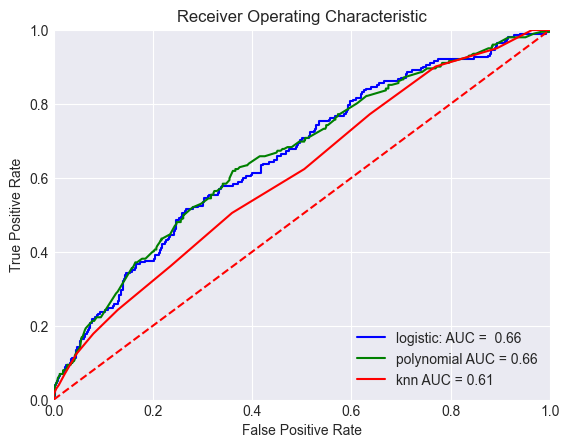

In [29]:
# plotting the current results

preds = y_val_pred_prob[:,1]
preds_poly = isotonic_log.predict_proba(X_val_poly)[:,1]
preds_knn = grid_search.predict_proba(X_val_stand)[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_k, tpr_k, threshold = metrics.roc_curve(y_val, preds_knn)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_k = metrics.auc(fpr_k, tpr_k)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
# Using SMOTE to deal with unbalanced data

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.8, random_state=1703)
under = RandomUnderSampler(sampling_strategy=1)
pipeline = Pipeline([('o', over), ('u', under)])

X_train_smote, y_train_smote = pipeline.fit_resample(X_train_stand.copy(), y_train.copy())
X_val_smote, y_val_smote = pipeline.fit_resample(X_trainval_stand.copy(), y_trainval.copy())
np.bincount(y_val_smote)

array([2361, 2361], dtype=int64)

In [31]:
# For some reason the X_train_smote has five thousand plus missing data. We will use KNNImputer to fill this void.

from sklearn.impute import KNNImputer

# Create an instance of the imputer
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values in X_train_smote
X_train_smote = imputer.fit_transform(X_train_smote)

In [32]:
# Using grid search with balanced data and calibrate the model

n_neighbors = np.arange(20,50)
param_grid = {'n_neighbors': n_neighbors}

knn_b = KNeighborsClassifier()
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=prec_scorer ,cv=3, verbose=2, n_jobs=-1)
isotonic_knn = CalibratedClassifierCV(grid_search_knn, cv=3, method='isotonic')

isotonic_knn.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=KNeighborsClassifier(),
                                              n_jobs=-1,
                                              param_grid={'n_neighbors': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                                              scoring=make_scorer(accuracy_score),
                                              verbose=2),
                       method='isotonic')

In [33]:
# classification report

y_pred_knn_b = isotonic_knn.predict(X_val_stand)
print(classification_report(y_val, y_pred_knn_b))

              precision    recall  f1-score   support

           0       0.79      0.67      0.72       590
           1       0.33      0.47      0.39       202

    accuracy                           0.62       792
   macro avg       0.56      0.57      0.56       792
weighted avg       0.67      0.62      0.64       792



c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


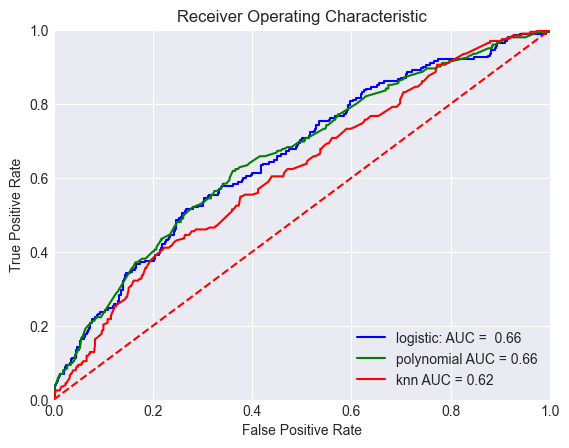

In [34]:
# plotting the result

preds_knn_b = isotonic_knn.predict_proba(X_val_stand)[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_k, tpr_k, threshold = metrics.roc_curve(y_val, preds_knn_b)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_k = metrics.auc(fpr_k, tpr_k)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 2.2.6 Gradient Boosting Classifier

In [35]:
# RandomizedSearch with cross validation using the GradientBoostingClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in np.linspace(start=100, stop=250, num=50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 10, num=10)]
min_samples_split = [int(x) for x in np.linspace(2, 10, num=9)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num=10)]
learning_rate = [round(x,5) for x in np.linspace(start=0.001, stop=1.5, num=50)]

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

gbm = GradientBoostingClassifier()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions=random_grid, n_iter=50, cv=3, verbose=2, random_state=4872, n_jobs=-1)
gbm_random.fit(X_train_smote, y_train_smote)
gbm_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 155,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'log2',
 'max_depth': 10,
 'learning_rate': 0.12337}

In [36]:
# classification report

y_pred_gbm = gbm_random.predict(X_val_stand)
print(classification_report(y_val, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       590
           1       0.40      0.26      0.32       202

    accuracy                           0.71       792
   macro avg       0.59      0.57      0.57       792
weighted avg       0.68      0.71      0.69       792



c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


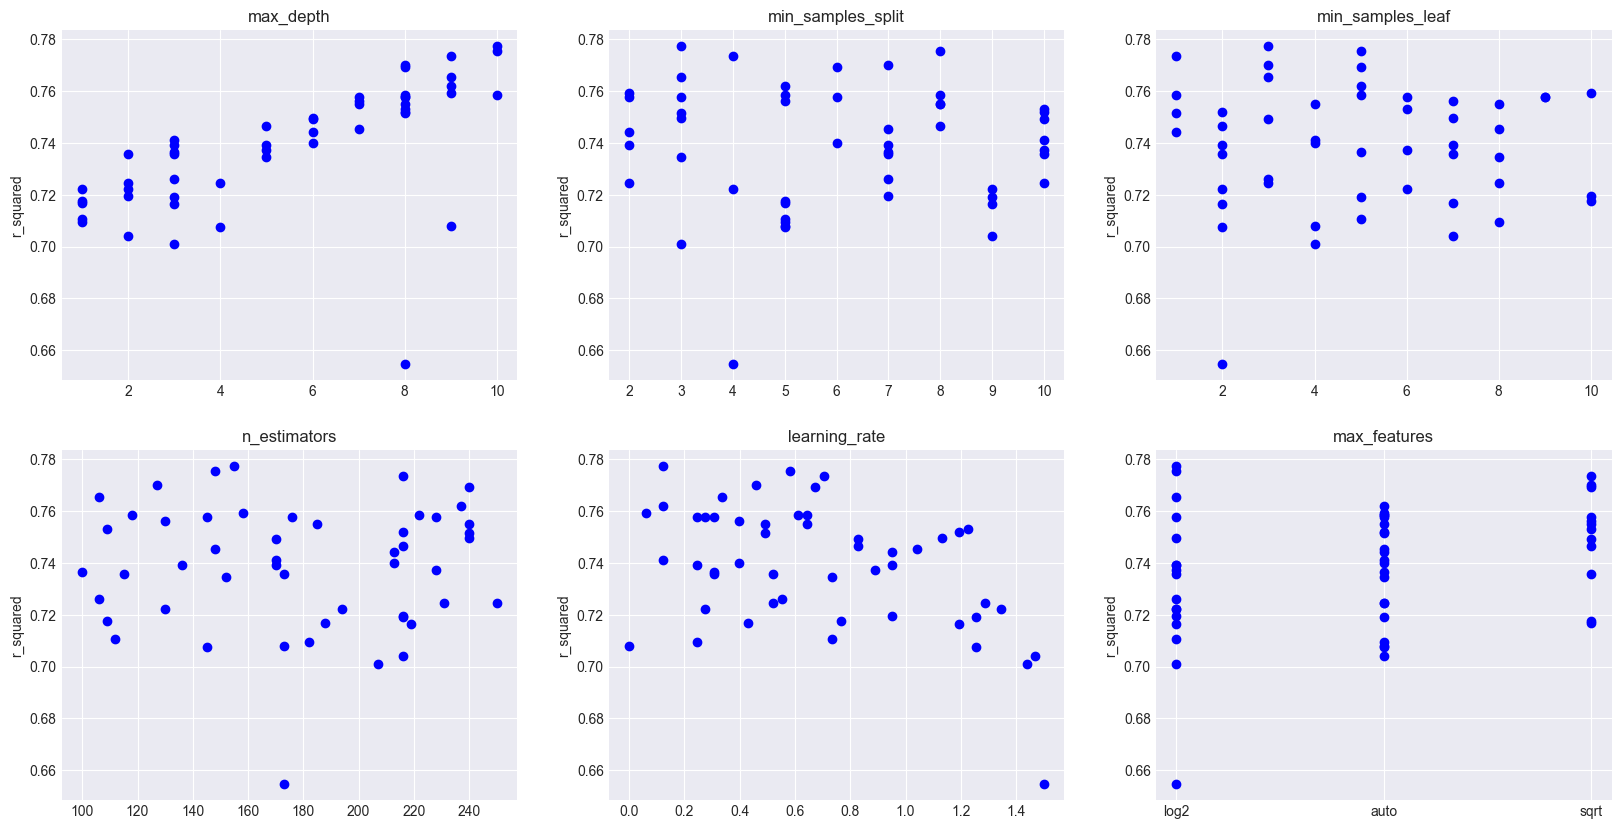

In [37]:
# plotting out the best parameters to use in the grid search

out2 = pd.DataFrame(gbm_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_learning_rate','param_max_features']

fig, axs = plt.subplots(2,3, figsize=(20,10))

axs[0,0].scatter(out2['param_max_depth'], out2['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out2['param_min_samples_split'], out2['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out2['param_min_samples_leaf'], out2['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out2['param_n_estimators'], out2['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out2['param_learning_rate'], out2['mean_test_score'], c='blue')
axs[1,1].set_title('learning_rate')

axs[1,2].scatter(out2['param_max_features'], out2['mean_test_score'], c='blue')
axs[1,2].set_title('max_features')

for ax in axs.flat: ax.set(ylabel='r_squared')

In [38]:
# using the best parameters in the grid search

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

n_estimators = [int(x) for x in np.linspace(230, 240, num=3)]
learning_rate = [x for x in np.linspace(0.1, 0.2, num=3)]
max_features = ['auto']
max_depth = [9,10]
min_samples_split = [5,3]
min_samples_leaf = [5,3]
                                            
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gbm = GradientBoostingClassifier()
gbm_grid = GridSearchCV(estimator=gbm, param_grid=random_grid, cv=3, verbose=2, n_jobs=-1)

isotonic_gbm = CalibratedClassifierCV(gbm_grid, cv=3, method='isotonic')
isotonic_gbm.fit(X_train_smote, y_train_smote)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past 

Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past 

Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past 

CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=GradientBoostingClassifier(),
                                              n_jobs=-1,
                                              param_grid={'learning_rate': [0.1,
                                                                            0.15000000000000002,
                                                                            0.2],
                                                          'max_depth': [9, 10],
                                                          'max_features': ['auto'],
                                                          'min_samples_leaf': [5,
                                                                               3],
                                                          'min_samples_split': [5,
                                                                                3],
                                                          'n_estimators': [230,
                                                                           235,
                                                                           240]},
                                              verbose=2),
                       method='isotonic')

In [39]:
# classification report

y_pred_gbm = isotonic_gbm.predict(X_val_stand)
print(classification_report(y_val, y_pred_gbm))

c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.77      0.93      0.84       590
           1       0.49      0.19      0.28       202

    accuracy                           0.74       792
   macro avg       0.63      0.56      0.56       792
weighted avg       0.70      0.74      0.70       792



c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


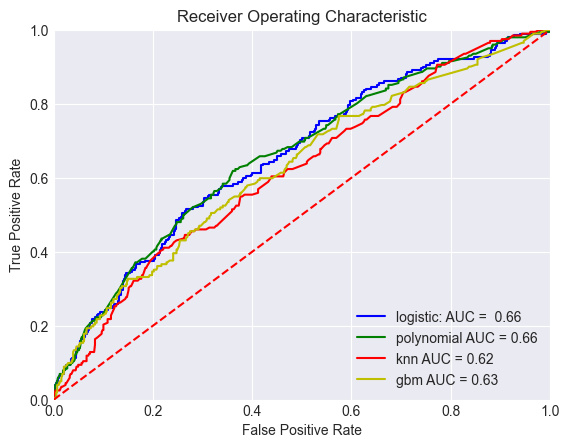

In [40]:
# plotting the results

preds_gbm = isotonic_gbm.predict_proba(X_val_stand)[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_k, tpr_k, threshold = metrics.roc_curve(y_val, preds_knn_b)
fpr_g, tpr_g, threshold = metrics.roc_curve(y_val, preds_gbm)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_k = metrics.auc(fpr_k, tpr_k)
roc_auc_g = metrics.auc(fpr_g, tpr_g)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)
plt.plot(fpr_g, tpr_g, 'y', label = 'gbm AUC = %0.2f' % roc_auc_g)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 2.2.7 Support Vector Machines

In [41]:
# using RandomizedSearch with cross validation to retrieve the best parameters to use in the grid search

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

C = [round(x,5) for x in np.linspace(start=0.001, stop=5, num=50)]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [round(x) for x in np.linspace(start=1, stop=5, num=15)]
gamma = [round(x,5) for x in np.linspace(start=0.001, stop=1, num=50)]

random_grid = {'C': C,
               'kernel': kernel,
               'degree':degree,
               'gamma': gamma}
svc = SVC()
svc_random = RandomizedSearchCV(estimator = svc, param_distributions=random_grid, n_iter=50, cv=3, verbose=2, random_state=4872, n_jobs=-1)
svc_random.fit(X_train_smote, y_train_smote)

print(svc_random.best_params_)
params = svc_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'kernel': 'rbf', 'gamma': 0.55147, 'degree': 5, 'C': 2.34747}


In [42]:
# classification report

from sklearn.metrics import classification_report

y_pred_svm = svc_random.predict(X_val_stand)
print(classification_report(y_val, y_pred_svm))

c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.97      0.85       590
           1       0.39      0.05      0.10       202

    accuracy                           0.74       792
   macro avg       0.57      0.51      0.47       792
weighted avg       0.66      0.74      0.65       792



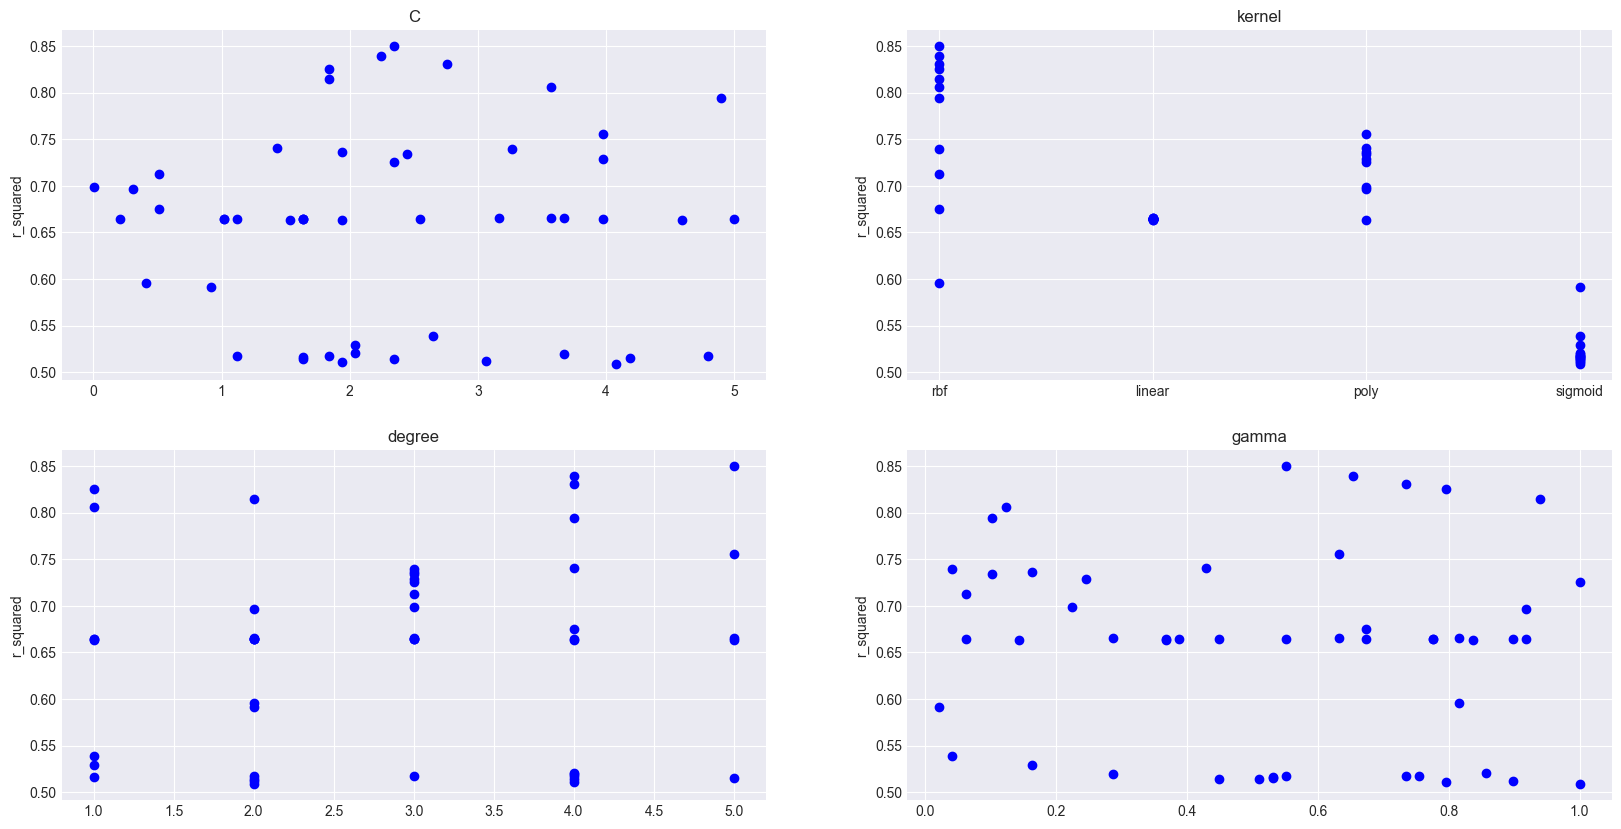

In [43]:
# plotting the parameters, the best ones will be used in the grid search

out2 = pd.DataFrame(svc_random.cv_results_)

xlabel_names = ['C',
               'kernel',
               'degree',
               'gamma']

fig, axs = plt.subplots(2,2, figsize=(20,10))

axs[0,0].scatter(out2['param_C'], out2['mean_test_score'], c='blue')
axs[0,0].set_title('C')

axs[0,1].scatter(out2['param_kernel'], out2['mean_test_score'], c='blue')
axs[0,1].set_title('kernel')

axs[1,0].scatter(out2['param_degree'], out2['mean_test_score'], c='blue')
axs[1,0].set_title('degree')

axs[1,1].scatter(out2['param_gamma'], out2['mean_test_score'], c='blue')
axs[1,1].set_title('gamma')

for ax in axs.flat: ax.set(ylabel='r_squared')

In [44]:
# using the best parameters with the grid search

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


C = [round(x,5) for x in np.linspace(start=2, stop=2.5, num=5)]
kernel = ['rbf']
degree = [5,4]
gamma = [round(x,5) for x in np.linspace(start=0.5, stop=0.6, num=4)]

random_grid = {'C': C,
               'kernel': kernel,
               'degree':degree,
               'gamma': gamma}
svc = SVC()
svc_grid = GridSearchCV(estimator=svc, param_grid=random_grid, cv=3, verbose=2, n_jobs=-1)

isotonic_svm = CalibratedClassifierCV(svc_grid, cv=3, method='isotonic')
isotonic_svm.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits


CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                                              param_grid={'C': [2.0, 2.125,
                                                                2.25, 2.375,
                                                                2.5],
                                                          'degree': [5, 4],
                                                          'gamma': [0.5,
                                                                    0.53333,
                                                                    0.56667,
                                                                    0.6],
                                                          'kernel': ['rbf']},
                                              verbose=2),
                       method='isotonic')

In [45]:
# classification report

y_pred_svm = isotonic_svm.predict(X_val_stand)
print(classification_report(y_val, y_pred_svm))

c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.94      0.83       590
           1       0.33      0.09      0.15       202

    accuracy                           0.72       792
   macro avg       0.54      0.51      0.49       792
weighted avg       0.64      0.72      0.66       792



c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


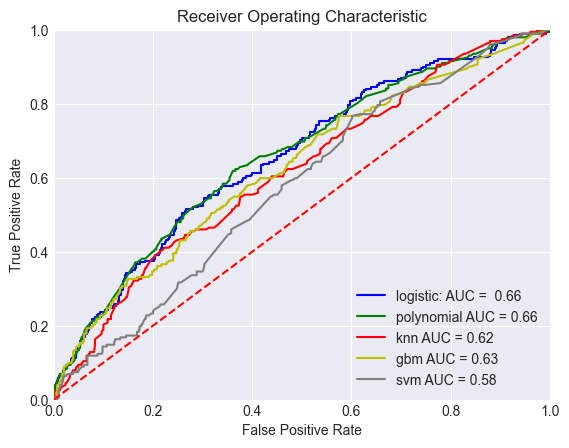

In [46]:
# plotting the results

preds_svm = isotonic_svm.predict_proba(X_val_stand)[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_k, tpr_k, threshold = metrics.roc_curve(y_val, preds_knn_b)
fpr_g, tpr_g, threshold = metrics.roc_curve(y_val, preds_gbm)
fpr_s, tpr_s, threshold = metrics.roc_curve(y_val, preds_svm)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_k = metrics.auc(fpr_k, tpr_k)
roc_auc_g = metrics.auc(fpr_g, tpr_g)
roc_auc_s = metrics.auc(fpr_s, tpr_s)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)
plt.plot(fpr_g, tpr_g, 'y', label = 'gbm AUC = %0.2f' % roc_auc_g)
plt.plot(fpr_s, tpr_s, 'grey', label = 'svm AUC = %0.2f' % roc_auc_s)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2.3 Evaluation

Looking at the most recent 'Receiver Operating Characteristic' plot we can determine the best classification model to use.

Polynomial and logistic classification are both at 0.66. We will use the polynomial classification model for our fitting and predicting the values for 'outcome_damage_inc'. 

In [59]:
# refitting using the best model

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

prec_scorer = make_scorer(metrics.accuracy_score)

C = [x for x in np.linspace(start=0.0001, stop=1, num=50)]

random_grid = {'C': C}

logreg_balanced = LogisticRegression(max_iter=1000) 

log_grid = GridSearchCV(estimator=logreg_balanced, param_grid=random_grid, scoring=prec_scorer, cv=3, verbose=2,  n_jobs=-1)
isotonic_log = CalibratedClassifierCV(log_grid, cv=3, method='isotonic')

#Fitting model (model + calibration)
isotonic_log.fit(X_val, y_val)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=LogisticRegression(max_iter=1000),
                                              n_jobs=-1,
                                              param_grid={'C': [0.0001,
                                                                0.02050612244897959,
                                                                0.04091224489795919,
                                                                0.06131836734693878,
                                                                0.08172448979591837,
                                                                0.10213061224489796,
                                                                0.12253673469387756,
                                                                0.14294285714285712,
                                                                0.16334897959183672,
                                                                0.18375510204081633,
                                                                0.2041612244897959,
                                                                0.224567346938775...
                                                                0.30619183673469386,
                                                                0.32659795918367346,
                                                                0.34700408163265306,
                                                                0.36741020408163266,
                                                                0.3878163265306122,
                                                                0.4082224489795918,
                                                                0.4286285714285714,
                                                                0.449034693877551,
                                                                0.4694408163265306,
                                                                0.4898469387755102,
                                                                0.5102530612244898,
                                                                0.5306591836734694,
                                                                0.551065306122449,
                                                                0.5714714285714285,
                                                                0.5918775510204082, ...]},
                                              scoring=make_scorer(accuracy_score),
                                              verbose=2),
                       method='isotonic')

In [65]:
# load dataset
score_cleaned = pd.read_csv('score_cleaned.csv')

# predicting the values
y_pred = isotonic_log.predict(X_test_stand)

# adding the outcome_damage_inc column with the predicted outcome
# again the X_test_stand returns 900+ rows, but I only need 496, so the first 496 will be used

score_cleaned['outcome_damage_inc'] = y_pred[:496]
score_cleaned.to_csv('score_cleaned.csv', index=False)